# Self-RAG

Self-RAG는 검색된 문서와 생성된 내용에 대한 자기 성찰/자기 평가를 포함하는 RAG 전략입니다.

논문에서는 다음과 같은 결정들이 이루어집니다:

1. 검색기 R에서 검색해야 하는가?
   - 입력: x (질문) 또는 x (질문), y (생성)
   - R을 사용하여 D 청크를 검색할 시기를 결정
   - 출력: 예, 아니오, 계속

2. 검색된 구절 D가 질문 x와 관련이 있는가?
   - 입력: D의 각 d에 대해 (x (질문), d (청크))
   - d가 x를 해결하는 데 유용한 정보를 제공하는지 판단
   - 출력: 관련 있음, 관련 없음

3. D의 각 청크에 대한 LLM 생성이 해당 청크와 관련이 있는가? (환각 등)
   - 입력: D의 각 d에 대해 x (질문), d (청크), y (생성)
   - y (생성)의 모든 검증 가능한 진술이 d에 의해 지원되는지 확인
   - 출력: 완전히 지원됨, 부분적으로 지원됨, 지원 없음

4. D의 각 청크에 대한 LLM 생성이 x (질문)에 대한 유용한 응답인가?
   - 입력: D의 각 d에 대해 x (질문), y (생성)
   - y (생성)가 x (질문)에 대한 유용한 응답인지 평가
   - 출력: 5, 4, 3, 2, 1

우리는 LangGraph를 사용하여 이러한 아이디어 중 일부를 처음부터 구현할 것입니다.


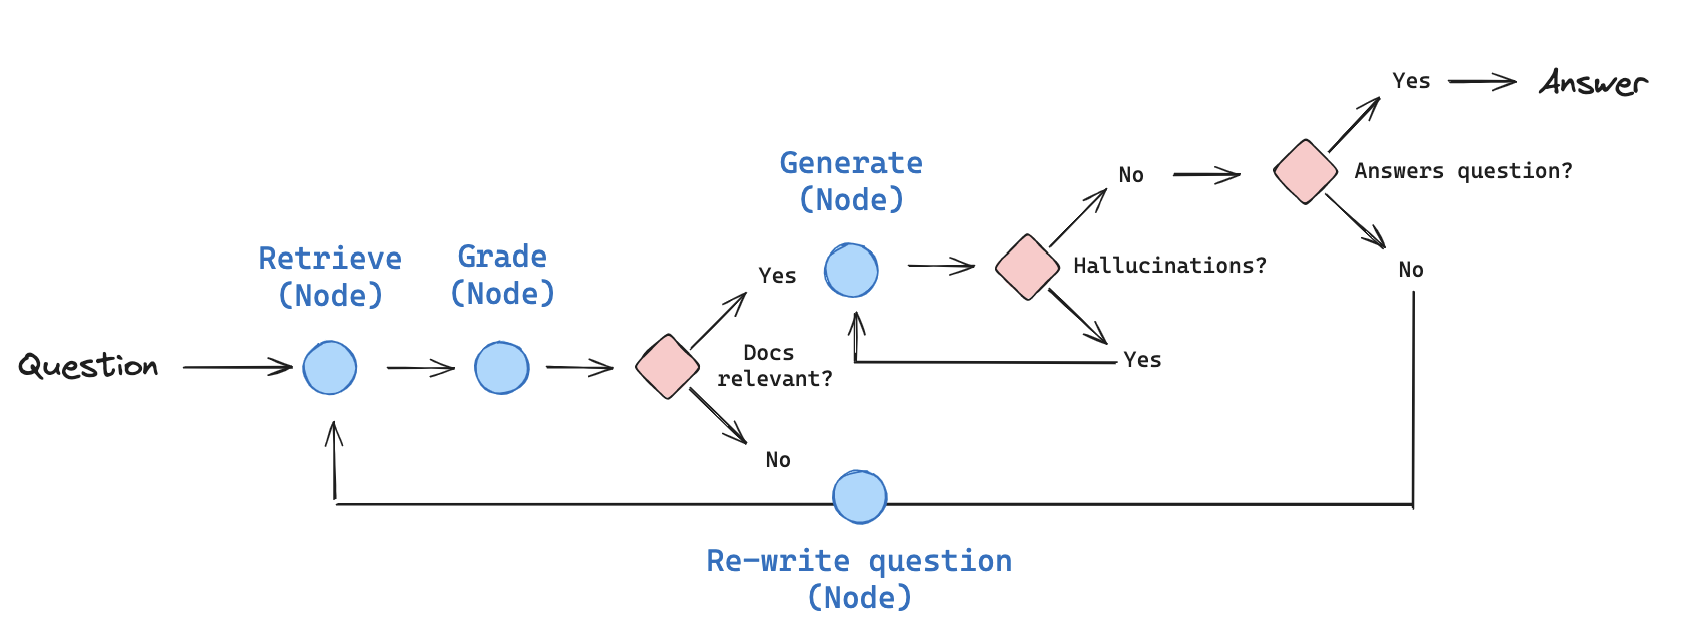

## Setup

먼저 필요한 패키지를 설치하고 API 키를 설정합시다

#%! pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

In [1]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

## Retriever

Let's index 3 blog posts.

In [2]:
# 필요한 라이브러리들을 임포트합니다.
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 검색할 블로그 포스트 URL들을 정의합니다.
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# 각 URL에서 문서를 로드하고, 모든 문서를 하나의 리스트로 합칩니다.
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# 문서를 작은 청크로 나누기 위한 텍스트 스플리터를 설정합니다.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
# 문서를 청크로 나눕니다.
doc_splits = text_splitter.split_documents(docs_list)

# 벡터 데이터베이스를 생성하고 문서를 추가합니다.
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
# 벡터 데이터베이스를 검색기로 사용할 수 있게 합니다.
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


## LLMs

### Retrieval Grader

In [3]:
# 필요한 라이브러리를 가져옵니다.
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# 문서 평가를 위한 데이터 모델을 정의합니다.
class GradeDocuments(BaseModel):
    """검색된 문서의 관련성을 확인하기 위한 이진 점수입니다."""

    binary_score: str = Field(
        description="문서가 질문과 관련이 있으면 'yes', 그렇지 않으면 'no'"
    )

# OpenAI의 ChatGPT 모델을 사용하여 LLM을 초기화합니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 평가를 위한 프롬프트를 설정합니다.
system = """당신은 사용자 질문에 대한 검색된 문서의 관련성을 평가하는 채점자입니다. 
    엄격한 테스트일 필요는 없습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. 
    문서에 사용자 질문과 관련된 키워드나 의미가 포함되어 있다면 관련성이 있다고 평가하세요. 
    문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 표시하세요."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 문서: \n\n {document} \n\n 사용자 질문: {question}"),
    ]
)

# 검색 평가기를 설정합니다.
retrieval_grader = grade_prompt | structured_llm_grader

# 예시 질문과 문서를 사용하여 평가를 수행합니다.
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate

In [4]:
# 필요한 라이브러리를 가져옵니다.
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# RAG 프롬프트를 가져옵니다.
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

# OpenAI의 ChatGPT 모델을 사용하여 LLM을 초기화합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 문서를 포맷팅하는 함수를 정의합니다.
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG 체인을 구성합니다.
rag_chain = prompt | llm | StrOutputParser()

# RAG 체인을 실행하고 결과를 출력합니다.
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/home/restful3/anaconda3/envs/langchain/lib/python3.11/site-packages/langsmith/client.py:5519: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
Agent memory in LLM-powered autonomous agents involves a long-term memory module that records a comprehensive list of the agent's experiences in natural language. This memory stream allows the agent to behave based on past experiences and interact with other agents. It is a key component that complements t

### Hallucination Grader

In [5]:
# 환각 평가를 위한 데이터 모델
class GradeHallucinations(BaseModel):
    """생성된 답변에 환각이 있는지 여부를 이진 점수로 평가합니다."""

    binary_score: str = Field(
        description="답변이 사실에 근거하고 있는지 여부, 'yes' 또는 'no'"
    )


# 함수 호출이 가능한 LLM 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 프롬프트 설정
system = """당신은 LLM이 생성한 답변이 검색된 사실들에 근거하고 있는지 평가하는 채점자입니다. \n 
     'yes' 또는 'no'로 이진 점수를 주세요. 'yes'는 답변이 주어진 사실들에 근거하고 있음을 의미합니다."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "사실 목록: \n\n {documents} \n\n LLM 생성 답변: {generation}"),
    ]
)

# 환각 평가기 설정 및 실행
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### Answer Grader

In [6]:
# 답변 평가를 위한 데이터 모델
class GradeAnswer(BaseModel):
    """질문에 대한 답변의 적절성을 이진 점수로 평가합니다."""

    binary_score: str = Field(
        description="답변이 질문을 해결하는지 여부, 'yes' 또는 'no'"
    )


# 함수 호출이 가능한 LLM 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 프롬프트 설정
system = """당신은 답변이 질문을 해결하거나 다루고 있는지 평가하는 채점자입니다. \n 
     'yes' 또는 'no'로 이진 점수를 주세요. 'yes'는 답변이 질문을 해결한다는 의미입니다."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "사용자 질문: \n\n {question} \n\n LLM 생성 답변: {generation}"),
    ]
)

# 답변 평가기 설정 및 실행
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

### Question Re-writer

In [7]:
# LLM 모델 설정
# ChatOpenAI를 사용하여 GPT-4 모델을 초기화합니다. temperature=0으로 설정하여 일관된 출력을 얻습니다.
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# 프롬프트 설정
# 시스템 메시지는 LLM에게 질문 재작성기 역할을 부여합니다.
system = """당신은 입력된 질문을 벡터 저장소 검색에 최적화된 더 나은 버전으로 변환하는 질문 재작성기입니다. 
     입력을 보고 기본적인 의미론적 의도/의미에 대해 추론해 보세요."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "다음은 초기 질문입니다: \n\n {question} \n 개선된 질문을 작성해 주세요.",
        ),
    ]
)

# 질문 재작성 파이프라인 설정
# 프롬프트, LLM, 문자열 출력 파서를 연결하여 파이프라인을 구성합니다.
question_rewriter = re_write_prompt | llm | StrOutputParser()

# 질문 재작성 실행
# 주어진 질문에 대해 재작성 파이프라인을 실행합니다.
question_rewriter.invoke({"question": question})

'에이전트 메모리란 무엇인가요?'

## Graph

흐름을 그래프로 표현합니다.

### Graph state

In [8]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 클래스입니다.
    
    이 클래스는 RAG(Retrieval-Augmented Generation) 시스템의 주요 구성 요소를 포함합니다.

    속성:
        question (str): 사용자가 입력한 원래 질문입니다.
        generation (str): LLM(Large Language Model)이 생성한 답변입니다.
        documents (List[str]): 검색된 관련 문서들의 리스트입니다.
    
    이 클래스는 TypedDict를 상속받아 각 속성의 타입을 명시적으로 정의합니다.
    이를 통해 코드의 가독성과 타입 안정성을 높일 수 있습니다.
    """

    question: str
    generation: str
    documents: List[str]

### Nodes

In [9]:
def retrieve(state):
    """
    문서를 검색하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        state (dict): 검색된 문서가 포함된 'documents' 키가 추가된 상태
    """
    print("---문서 검색 중---")
    question = state["question"]

    # 문서 검색 수행
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    답변을 생성하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        state (dict): LLM이 생성한 답변이 포함된 'generation' 키가 추가된 상태
    """
    print("---답변 생성 중---")
    question = state["question"]
    documents = state["documents"]

    # RAG를 이용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    검색된 문서가 질문과 관련이 있는지 평가하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        state (dict): 관련성이 있는 문서만 필터링된 'documents' 키가 업데이트된 상태
    """

    print("---문서의 질문 관련성 확인 중---")
    question = state["question"]
    documents = state["documents"]

    # 각 문서 평가
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---평가 결과: 문서 관련성 있음---")
            filtered_docs.append(d)
        else:
            print("---평가 결과: 문서 관련성 없음---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    더 나은 질문을 생성하기 위해 쿼리를 변환하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        state (dict): 재작성된 질문으로 'question' 키가 업데이트된 상태
    """

    print("---쿼리 변환 중---")
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Edges

In [10]:
def decide_to_generate(state):
    """
    답변을 생성할지 또는 질문을 다시 생성할지 결정하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        str: 다음에 호출할 노드를 결정하는 이진 결정
    """

    print("---평가된 문서 검토 중---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 check_relevance에 의해 필터링되었습니다
        # 새로운 쿼리를 생성할 것입니다
        print(
            "---결정: 모든 문서가 질문과 관련이 없습니다. 쿼리를 변환합니다---"
        )
        return "transform_query"
    else:
        # 관련 있는 문서가 있으므로 답변을 생성합니다
        print("---결정: 답변 생성---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    생성된 답변이 문서에 근거하고 질문에 답변하는지 판단하는 함수입니다.

    매개변수:
        state (dict): 현재 그래프의 상태

    반환값:
        str: 다음에 호출할 노드를 결정하는 결과
    """

    print("---환각 여부 확인 중---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # 환각 여부 확인
    if grade == "yes":
        print("---결정: 생성된 답변이 문서에 근거합니다---")
        # 질문 답변 여부 확인
        print("---생성된 답변과 질문 비교 평가 중---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---결정: 생성된 답변이 질문을 다룹니다---")
            return "useful"
        else:
            print("---결정: 생성된 답변이 질문을 다루지 않습니다---")
            return "not useful"
    else:
        print("---결정: 생성된 답변이 문서에 근거하지 않습니다. 다시 시도합니다---")
        return "not supported"

### Build Graph

The just follows the flow we outlined in the figure above.

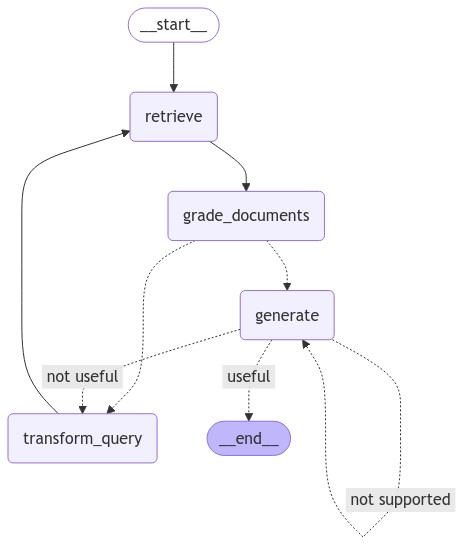

In [11]:
# langgraph 라이브러리에서 필요한 클래스들을 가져옵니다.
from langgraph.graph import END, StateGraph, START

# GraphState를 사용하여 새로운 워크플로우 그래프를 생성합니다.
workflow = StateGraph(GraphState)

# 그래프의 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve)  # 문서 검색 노드
workflow.add_node("grade_documents", grade_documents)  # 문서 평가 노드
workflow.add_node("generate", generate)  # 답변 생성 노드
workflow.add_node("transform_query", transform_query)  # 쿼리 변환 노드

# 그래프의 구조를 구축합니다.
workflow.add_edge(START, "retrieve")  # 시작점에서 문서 검색으로
workflow.add_edge("retrieve", "grade_documents")  # 문서 검색 후 문서 평가로

# 문서 평가 후 조건에 따라 다음 단계 결정
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",  # 쿼리 변환이 필요한 경우
        "generate": "generate",  # 답변 생성이 가능한 경우
    },
)

workflow.add_edge("transform_query", "retrieve")  # 쿼리 변환 후 다시 문서 검색으로

# 답변 생성 후 품질 평가에 따른 다음 단계 결정
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # 답변이 부적절한 경우 다시 생성
        "useful": END,  # 유용한 답변인 경우 종료
        "not useful": "transform_query",  # 유용하지 않은 경우 쿼리 변환
    },
)

# 워크플로우 그래프를 컴파일하여 실행 가능한 앱으로 만듭니다.
app = workflow.compile()

# 그래프 시각화를 위한 라이브러리를 가져옵니다.
from IPython.display import Image, display
  
# 컴파일된 앱의 그래프를 Mermaid 형식의 PNG 이미지로 생성하고 표시합니다.
display(Image(app.get_graph().draw_mermaid_png()))

### Use the graph

In [12]:
from pprint import pprint

# 그래프 실행 및 결과 출력
print("그래프를 실행하고 각 노드의 출력을 확인해보겠습니다.")

# 입력 질문 설정
inputs = {"question": "에이전트 메모리의 다양한 유형들은 어떻게 작동하나요?"}
print(f"입력 질문: {inputs['question']}\n")

# 그래프 실행 및 각 노드의 출력 표시
print("각 노드의 실행 결과:")
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"노드 '{key}'가 실행되었습니다.")
        # 필요한 경우 각 노드의 전체 상태를 출력할 수 있습니다.
        # pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# 최종 생성된 답변 출력
print("최종 생성된 답변:")
pprint(value["generation"])
print("\n이렇게 그래프의 각 노드를 거쳐 최종 답변이 생성되었습니다.")

그래프를 실행하고 각 노드의 출력을 확인해보겠습니다.
입력 질문: 에이전트 메모리의 다양한 유형들은 어떻게 작동하나요?

각 노드의 실행 결과:
---문서 검색 중---
노드 'retrieve'가 실행되었습니다.

---

---문서의 질문 관련성 확인 중---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 없음---
---평가된 문서 검토 중---
---결정: 답변 생성---
노드 'grade_documents'가 실행되었습니다.

---

---답변 생성 중---
---환각 여부 확인 중---
---결정: 생성된 답변이 문서에 근거합니다---
---생성된 답변과 질문 비교 평가 중---
---결정: 생성된 답변이 질문을 다루지 않습니다---
노드 'generate'가 실행되었습니다.

---

---쿼리 변환 중---
노드 'transform_query'가 실행되었습니다.

---

---문서 검색 중---
노드 'retrieve'가 실행되었습니다.

---

---문서의 질문 관련성 확인 중---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 없음---
---평가된 문서 검토 중---
---결정: 답변 생성---
노드 'grade_documents'가 실행되었습니다.

---

---답변 생성 중---
---환각 여부 확인 중---
---결정: 생성된 답변이 문서에 근거합니다---
---생성된 답변과 질문 비교 평가 중---
---결정: 생성된 답변이 질문을 다루지 않습니다---
노드 'generate'가 실행되었습니다.

---

---쿼리 변환 중---
노드 'transform_query'가 실행되었습니다.

---

---문서 검색 중---
노드 'retrieve'가 실행되었습니다.

---

---문서의 질문 관련성 확인 중---
---

In [13]:
# 입력 질문 설정
inputs = {"question": "사고 연쇄 프롬프팅(chain of thought prompting)은 어떻게 작동하나요?"}

print("그래프를 실행하고 각 노드의 출력을 확인해보겠습니다.")
print(f"입력 질문: {inputs['question']}\n")

print("각 노드의 실행 결과:")
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"노드 '{key}'가 실행되었습니다.")
        # 필요한 경우 각 노드의 전체 상태를 출력할 수 있습니다.
        # pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

print("최종 생성된 답변:")
pprint(value["generation"])
print("\n이렇게 그래프의 각 노드를 거쳐 최종 답변이 생성되었습니다.")

그래프를 실행하고 각 노드의 출력을 확인해보겠습니다.
입력 질문: 사고 연쇄 프롬프팅(chain of thought prompting)은 어떻게 작동하나요?

각 노드의 실행 결과:
---문서 검색 중---
노드 'retrieve'가 실행되었습니다.

---

---문서의 질문 관련성 확인 중---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가 결과: 문서 관련성 있음---
---평가된 문서 검토 중---
---결정: 답변 생성---
노드 'grade_documents'가 실행되었습니다.

---

---답변 생성 중---
---환각 여부 확인 중---
---결정: 생성된 답변이 문서에 근거합니다---
---생성된 답변과 질문 비교 평가 중---
---결정: 생성된 답변이 질문을 다룹니다---
노드 'generate'가 실행되었습니다.

---

최종 생성된 답변:
('사고 연쇄 프롬프팅(chain of thought prompting)은 모델이 단계별로 사고 과정을 통해 추론을 하도록 유도하는 '
 '방법입니다. 이를 위해 "Let\'s think step by step"와 같은 자연어 문구를 사용하여 모델이 먼저 추론 체인을 '
 '생성하고, 그 후에 답을 도출하도록 합니다. 또한, 다양한 답변을 샘플링하고 다수결을 통해 최종 답변을 결정하는 자기 일관성 샘플링 '
 '방법도 사용됩니다.')

이렇게 그래프의 각 노드를 거쳐 최종 답변이 생성되었습니다.
